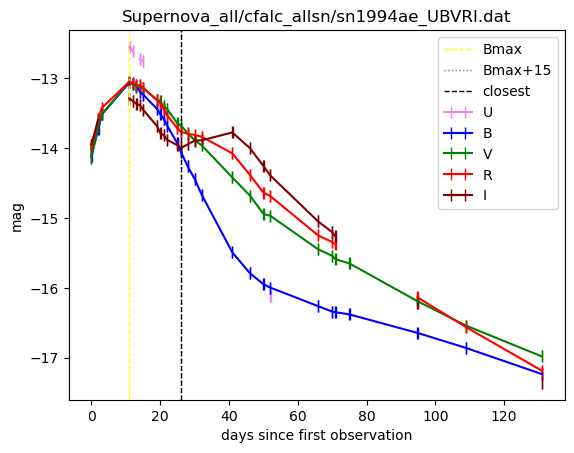

Bmax @ day 11.04 with mag -13.059
Bmax+15 @ day 26.01 with mag -14.048
Δm= -0.99


Mmax(V)= -10.99
d= 3.86




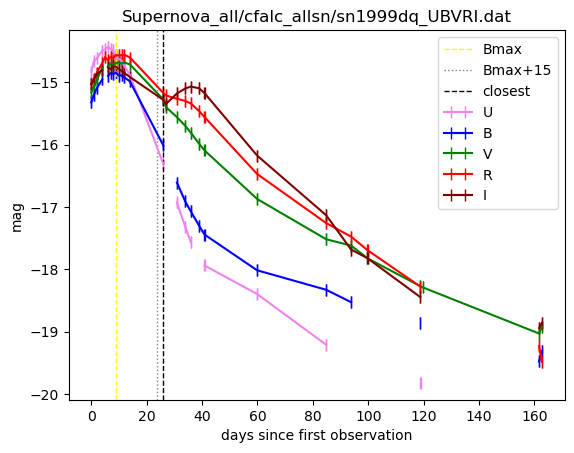

Bmax @ day 8.90 with mag -14.845
Bmax+15 @ day 25.97 with mag -16.009
Δm= -1.16


Mmax(V)= -11.05
d= 1.74






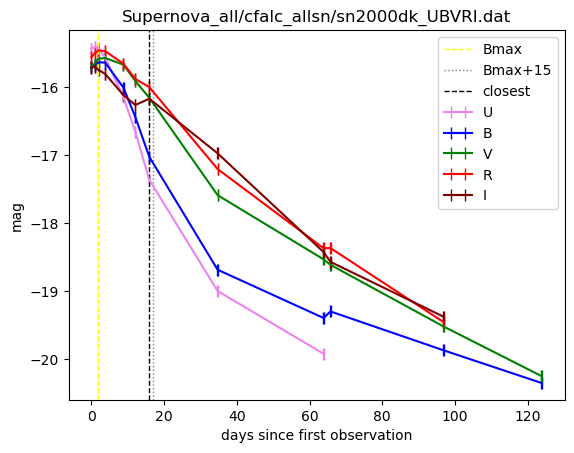

Bmax @ day 1.96 with mag -15.63
Bmax+15 @ day 15.93 with mag -17.021
Δm= -1.39


Mmax(V)= -11.11
d= 1.25








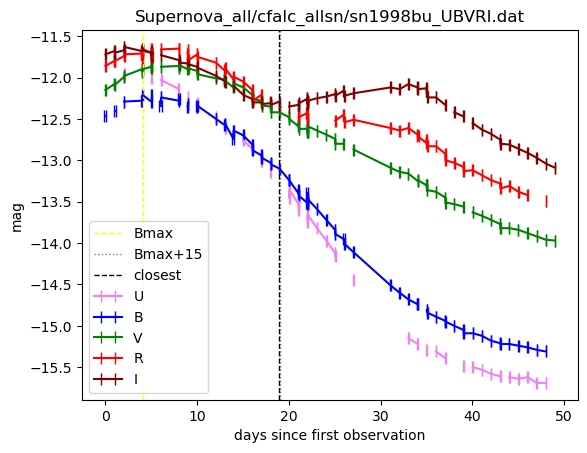

Bmax @ day 4.05 with mag -12.21
Bmax+15 @ day 18.97 with mag -13.1
Δm= -0.89


Mmax(V)= -10.95
d= 5.60






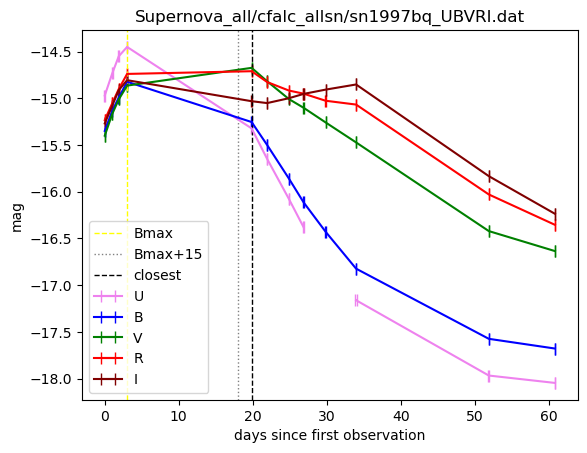

Bmax @ day 3.02 with mag -14.824
Bmax+15 @ day 19.85 with mag -15.255
Δm= -0.43


Mmax(V)= -10.72
d= 1.51








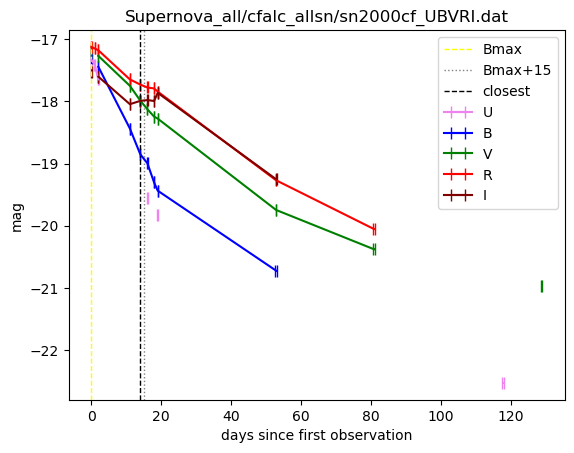

Bmax @ day 0.00 with mag -17.302
Bmax+15 @ day 13.99 with mag -18.851
Δm= -1.55


Mmax(V)= -11.14
d= 0.59






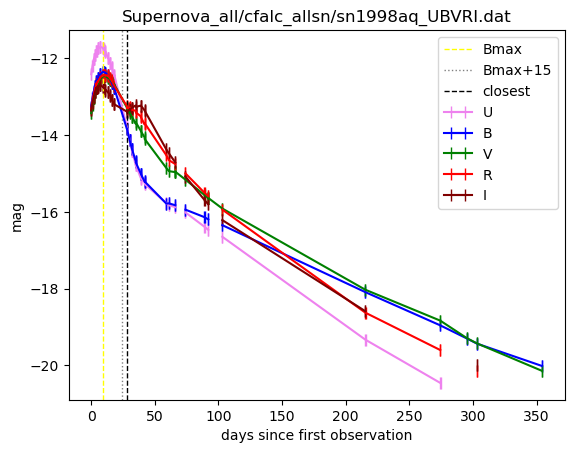

Bmax @ day 9.13 with mag -12.357
Bmax+15 @ day 28.06 with mag -13.843
Δm= -1.49


Mmax(V)= -11.13
d= 5.69




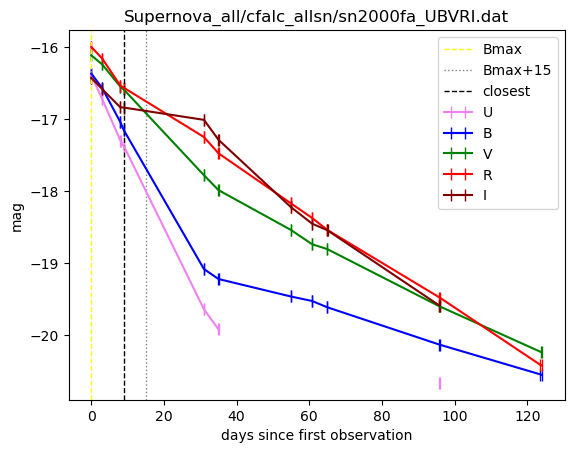

Bmax @ day 0.00 with mag -16.364
Bmax+15 @ day 8.91 with mag -17.148
Δm= -0.78


Mmax(V)= -10.90
d= 0.81






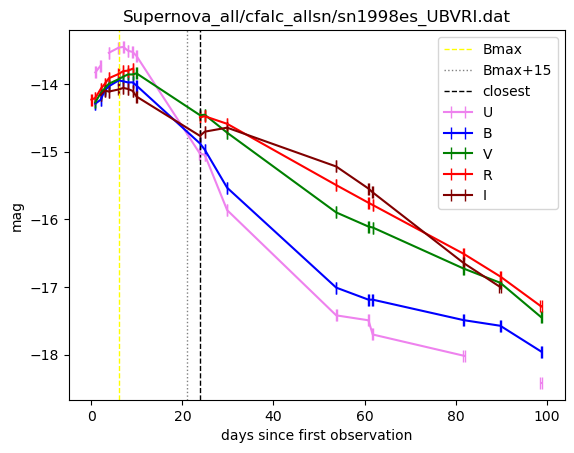

Bmax @ day 5.98 with mag -13.945
Bmax+15 @ day 23.85 with mag -14.877
Δm= -0.93


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import math
from sympy import symbols, Eq, init_printing

filters= [["U", "violet"], ["B", "blue"], ["V", "green"], ["R", "red"], ["I", "#800000"]]

H0=65

init_printing()
M, delta_m_15, delta_m2_15, logH0 = symbols('M_{max}(V) Δm_{15}(B) Δm²_{15}(B) log_{10}({H0})')
phillips_eq = Eq(M, ( 0.736 * delta_m_15 + 0.182 * delta_m2_15 ) + 5 * logH0 - 19.504 )


for file in glob.glob("Supernova_all/cfalc_allsn/*_UBVRI.dat"):
    try:
        # read the data file into a dataframe
        df = pd.read_table(file, comment="#", sep="[ \t]+", engine="python", header=0, names=["HJD", "U", "Uerr", "B", "Berr", "V", "Verr", "R", "Rerr", "I", "Ierr"])

        # compute, if 10+ observations are available
        if len(df) >= 10:
            # remove missing data
            df[df == 99.999] = None
            df[df == 99.99] = None
            df[df == 9.999] = None

            # convert HJD to days from first observation
            df["HJD"]-= df["HJD"].iat[0]
            
            # correct mag to -mag
            for filter, color in filters:
                df[filter]= -df[filter]
            
            # plot light curves for each filter
            for filter, color in filters:
                plt.errorbar(df["HJD"].values, df[filter].values, label=filter, color=color, xerr=df[filter+"err"].values, capsize=4)

            max_index= df["B"].idxmax()
            max_day=df["HJD"].iat[max_index]
            max_day15=max_day+15
            closest_index=(df["HJD"]-max_day15).abs().idxmin()
            closest_day=df["HJD"].iat[closest_index]
            plt.axvline(x=max_day, color='yellow', linestyle='--', linewidth=1, label='Bmax')
            plt.axvline(x=max_day15, color='grey', linestyle='dotted', linewidth=1, label='Bmax+15')
            plt.axvline(x=closest_day, color='black', linestyle='--', linewidth=1, label='closest')
            
            plt.title(file)
            plt.xlabel("days since first observation")
            plt.ylabel("mag")
            plt.legend()
            
            # show the plot
            plt.show()

            # print our findings
            max_mag=df["B"].iat[max_index]
            day15_mag=df["B"].iat[closest_index]
            delta_mag=day15_mag-max_mag
            print(f"Bmax @ day {max_day:.2f} with mag {max_mag}")
            print(f"Bmax+15 @ day {closest_day:.2f} with mag {day15_mag}")
            print(f"Δm= {delta_mag:.2f}")

            display(phillips_eq)
#            print(pretty(phillips_eq, use_unicode=True))
            
            M_max= -19.504 + 0.736*delta_mag + 0.182*delta_mag*delta_mag + 5*math.log10(H0)
            d=10**((max_mag - M_max + 5) / 5)
            print(f"Mmax(V)= {M_max:.2f}")
            print(f"d= {d:.2f} pc")
            
    except Exception as oops:
        print(f"{file} ignored due to error: {oops}")

    print()
    print()
    